In [1]:
import numpy as np
import hera_pspec
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import matplotlib
matplotlib.rc('text', usetex=True)
matplotlib.rc('font', family='serif')

In [2]:
realpathhigh = '/lustre/aoc/projects/hera/plaplant/HERA19Golden/CalibratedData/LSThrs_10.5_23.0/FREQrng_530_730/'
realpathlow = '/lustre/aoc/projects/hera/plaplant/HERA19Golden/CalibratedData/LSThrs_10.5_23.0/FREQrng_150_350/'
simpathhigh = '/lustre/aoc/projects/hera/pchichur/HERA19/Simulation2/LSThrs_10.5_23.0/FREQrng_530_730/'
simpathlow = '/lustre/aoc/projects/hera/pchichur/HERA19/Simulation2/LSThrs_10.5_23.0/FREQrng_150_350/'
savepath = '/lustre/aoc/projects/hera/pchichur/HERA19/final_paper_plots_redone/'

rI = 'zen.2457548.16700_66112.pI.HH.uvcRPCS.uvh5.UVPavg'
rQ = 'zen.2457548.16700_66112.pQ.HH.uvcRPCS.uvh5.UVPavg'
rU = 'zen.2457548.16700_66112.pU.HH.uvcRPCS.uvh5.UVPavg'
rV = 'zen.2457548.16700_66112.pV.HH.uvcRPCS.uvh5.UVPavg'

sI = 'zen.2457755.58922_11048.pI.HH.uvCP.uvh5.UVPavg'
sQ = 'zen.2457755.58922_11048.pQ.HH.uvCP.uvh5.UVPavg'
sU = 'zen.2457755.58922_11048.pU.HH.uvCP.uvh5.UVPavg'
sV = 'zen.2457755.58922_11048.pV.HH.uvCP.uvh5.UVPavg'

realhigh = [realpathhigh + rI, realpathhigh + rQ, realpathhigh + rU, realpathhigh + rV]
reallow = [realpathlow + rI, realpathlow + rQ, realpathlow + rU, realpathlow + rV]
simhigh = [simpathhigh + sI, simpathhigh + sQ, simpathhigh + sU, simpathhigh + sV]
simlow = [simpathlow + sI, simpathlow + sQ, simpathlow + sU, simpathlow + sV]

real = [realhigh, reallow]
sim = [simhigh, simlow]
pols = ['pI', 'pQ', 'pU', 'pV']
highlow = ['High Band', 'Low Band']
y1s = [[10**14.5, 10**12.5, 10**12.5, 10**11],[10**15.5, 10**14, 10**14, 10**11.5]]
y2s = np.array(y1s)*10**4
y2s[-1][-1] = 10**16.5

#real = [[realpathhigh+rI]]
#sim = [[simpathhigh+sI]]
#real = [realhigh]
#sim = [simhigh]
#real = [[realpathhigh+rI],[realpathlow+rI]]
#sim = [[simpathhigh+sI],[simpathlow+sI]]

In [26]:
def plot(real, sim, highlow, y1s, y2s, log, inset, QUmax=[None,None]):
    
    plotted_real_data = []
    plotted_sim_data = []
    
    if log:
        sharey = True
        wspace=0
    else:
        sharey = False
        wspace=.15
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15,12), sharex=False, sharey=sharey)
    plt.subplots_adjust(wspace=wspace, hspace=.43)

    for rowreal, rowsim, rowaxes, band, rowy1, rowy2, QUmaxval in zip(real, sim, axes, highlow, y1s, y2s, QUmax):
        for realuvp, simuvp, ax, pol, y1, y2 in zip(rowreal, rowsim, rowaxes, pols, rowy1, rowy2):
            #read uvps, average data for shortest baseline group
            uvp_sim = hera_pspec.UVPSpec()
            uvp_sim.read_hdf5(simuvp)
            blp_grps_sim, lens, angs, tags = hera_pspec.utils.get_blvec_reds(uvp_sim, bl_error_tol=1.0, match_bl_lens=True)
            bl_sim = blp_grps_sim[0][0]
            
            uvp_real = hera_pspec.UVPSpec()
            uvp_real.read_hdf5(realuvp)
            blp_grps_real, lens, angs, tags = hera_pspec.utils.get_blvec_reds(uvp_real, bl_error_tol=1.0, match_bl_lens=True)
            bl_real = blp_grps_real[0][0]

            sim_data = np.squeeze(uvp_sim.get_data((0, bl_sim, pol)))
            real_data = np.squeeze(uvp_real.get_data((0, bl_real, pol)))
            plotted_sim_data.append(sim_data)
            plotted_real_data.append(real_data)

            #blp_grps_real, lens, angs, tags = hera_pspec.utils.get_blvec_reds(uvp_real, bl_error_tol=1.0, match_bl_lens=True)
            hera_pspec.plot.delay_spectrum(uvp_sim, [bl_sim], 0, pol, legend=False, ax=ax, delay=False,component='abs', logscale=log)
            hera_pspec.plot.delay_spectrum(uvp_real, [bl_real], 0, pol, legend=False, ax=ax, delay=False,component='abs', logscale=log)

            if not log:
                if (pol=='pQ' or pol=='pU') and log==False and QUmaxval is not None:
                    ax.set_ylim(top=QUmaxval, bottom=None)
                #ax.set_ylim(bottom=-.1)
                
            simmax = np.max(np.abs(sim_data))
            realmax = np.max(np.abs(real_data))
            ax.annotate(np.format_float_scientific(simmax,2), xy=(0,simmax), fontsize=12, xytext=(-50, -1), textcoords='offset points')
            ax.annotate(np.format_float_scientific(realmax,2), xy=(0,realmax), fontsize=12, xytext=(-50, -1), textcoords='offset points')
            
            if pol != 'pI':
                ax.set_ylabel('')
            if pol == 'pV':
                ax.legend(['Simulation', 'Observation'])
                axR = ax.twinx()
                axR.set_ylabel(band, fontsize=16)
                axR.set_yticklabels('')
                axR.yaxis.set_ticks_position('none')

            #get the x axes correctly zoomed in
            axT = ax.twiny()
            delays = uvp_real.get_dlys(0) * 10**9
            if not log:
                for tick in axT.get_xaxis().get_major_ticks():
                    tick.set_pad(8.)
                    tick.label1 = tick._get_text1()
            axT.set_xlim([delays[0],delays[-1]])
            if log:
                labelpad=10
            else:
                labelpad=8
            axT.set_xlabel(r"$\tau$ $[{\rm ns}]$", fontsize=16, labelpad=labelpad)
            if log:
                scale = .465
            else:
                scale = .06
            axT.set_xlim([lim*scale for lim in axT.get_xlim()])
            ax.set_xlim([lim*scale for lim in ax.get_xlim()])

            if inset:
                #make inset
                axins = zoomed_inset_axes(ax,3,loc=3)
                x1, x2 = -.15, .15
                axins.set_xlim(x1,x2)
                axins.set_ylim(y1,y2)
                for line in ax.lines:
                    axins.plot(line.get_xdata(), line.get_ydata())
                mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")
                axins.set_yscale('log')
                axins.grid()
                axins.yaxis.set_ticks_position('none')
                axins.xaxis.set_ticks_position('none')
                axins.set_yticklabels('')
                axins.set_xticklabels('')

            ax.grid()
            ax.set_title(pol, pad=45)
    return fig, axes, plotted_sim_data, plotted_real_data, delays, uvp_real.get_kparas(0)

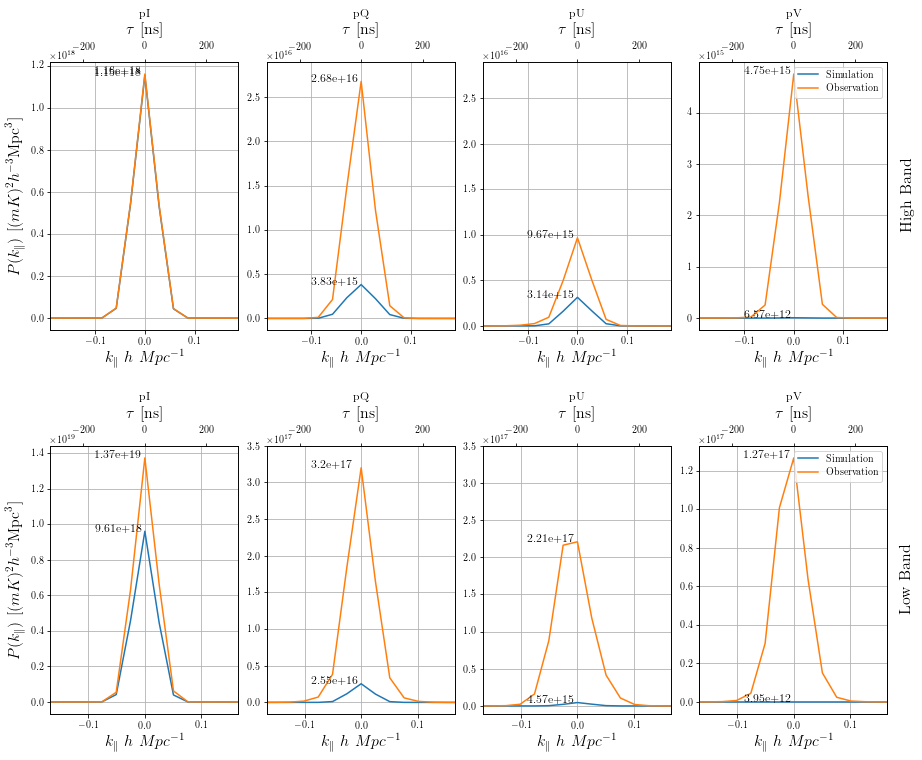

In [27]:
f, a, plotted_sim_data, plotted_real_data, delays, kparas  = plot(real, sim, highlow, y1s, y2s, log=False, inset=False, QUmax=[2.9*10**16, 3.5*10**17])
f.savefig(savepath + 'ps_peak_zoom.pdf', bbox_inches='tight')

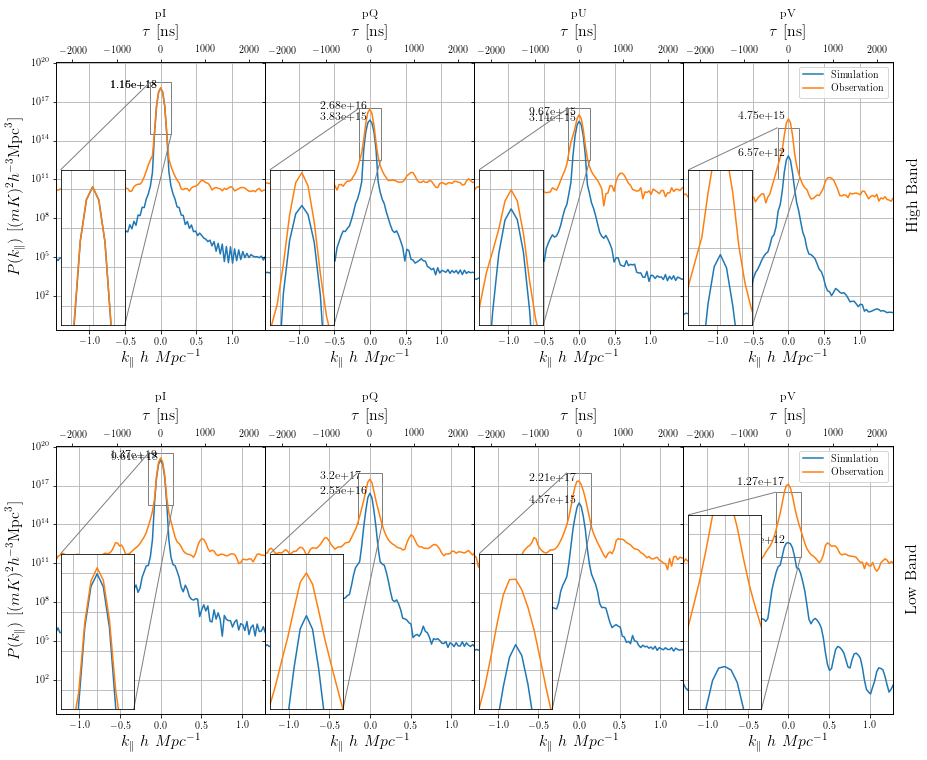

In [17]:
f, a, plotted_sim_data, plotted_real_data, delays, kparas = plot(real, sim, highlow, y1s, y2s, log=True, inset=True)
f.savefig(savepath + 'real_sim_compare.pdf', bbox_inches='tight')

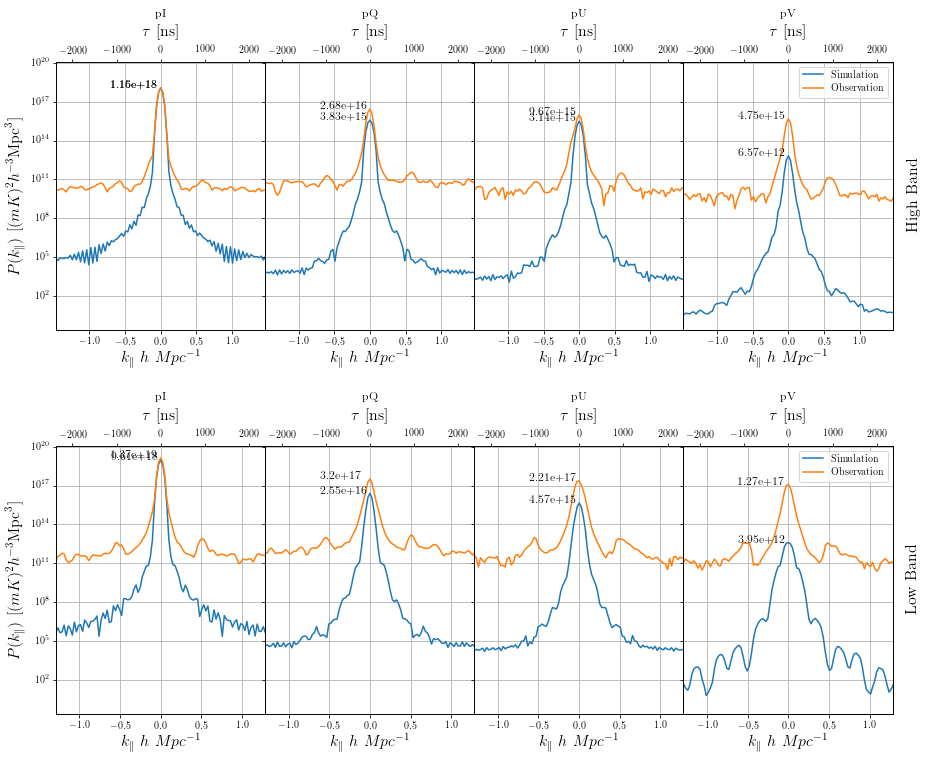

In [12]:
f, a, plotted_sim_data, plotted_real_data, delays, kparas = plot(real, sim, highlow, y1s, y2s, log=True, inset=False)
f.savefig(savepath + 'real_sim_compare_noinset.pdf', bbox_inches='tight')

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(15, 6), sharey=True, sharex=True)
uvps = []
pols = ['pI','pQ','pU','pV']
plt.subplots_adjust(wspace=0, hspace=0.1)
for dfile in dfiles:
    uvp = hera_pspec.UVPSpec()
    uvp.read_hdf5(dfile)
    uvps.append(uvp)
for ax, uvp, pol in zip(axes, uvps, pols):
    blp_grps, lens, angs, tags = hera_pspec.utils.get_blvec_reds(uvp, bl_error_tol=1.0, match_bl_lens=True)
    f = hera_pspec.plot.delay_spectrum(uvp, blp_grps, 0, pol, average_blpairs=True, average_times=True, legend=False, ax=ax, delay=False)
    if pol != 'pI':
        ax.set_ylabel('')
    if pol == 'pV':
        ax.legend([str(np.round(l,1))+' m' for l in lens])
        
    axT = ax.twiny()
    delays = uvp.get_dlys(0) * 10**9
    axT.set_xlim([delays[0],delays[-1]])
    axT.set_xlabel(r"$\tau$ $[{\rm ns}]$", fontsize=16)
    
    scale = .48
    axT.set_xlim([lim*scale for lim in axT.get_xlim()])
    if pol=='pV':
        ax.set_xlim([lim*scale for lim in ax.get_xlim()])
    
    horizons = uvp.get_blpair_seps() / conversions.units.c * 1e9
    #horizons = np.array([horizons[0], horizons[-1]])
    horizons = np.array([horizons[-1]])
    avg_z = uvp.cosmo.f2z(np.mean(uvp.freq_array[uvp.spw_to_freq_indices(0)]))
    horizons *= uvp.cosmo.tau_to_kpara(avg_z) / 1e9
    for horizon in horizons:
        ax.axvline(horizon, linestyle='--', color='k', linewidth=.7)
        ax.axvline(-horizon, linestyle='--', color='k', linewidth=.7)
    #ax.set_xlim([-2400,2400])
    
    ax.set_title(pol,pad=45)
    ax.grid()

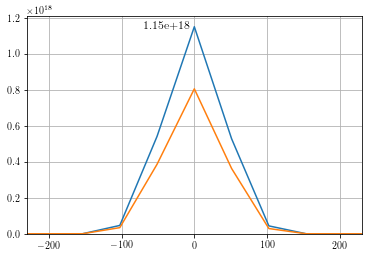

In [77]:
plot = 0
plt.plot(delays, np.abs(plotted_sim_data[plot]))
plt.plot(delays, np.abs(plotted_real_data[plot]))
plt.xlim([-230,230])
plt.ylim()
plt.grid()
#delays, kparas
#simmax = np.format_float_scientific(np.max(np.abs(plotted_sim_data[plot])),2)
simmax = np.max(np.abs(plotted_sim_data[plot]))
plt.annotate(np.format_float_scientific(simmax,2), xy=(0,simmax), fontsize=12, xytext=(-50, -3), textcoords='offset points')
plt.show()

In [26]:
np.savez(savepath+'ps_comparison_plot_data.npz', plotted_sim_data=plotted_sim_data, plotted_real_data=plotted_real_data, delays=delays, kparas=kparas)

In [111]:
d = np.load(savepath+'ps_comparison_plot_data.npz')
plotted_sim_data = d['plotted_sim_data']
plotted_sim_data = np.array([plotted_sim_data[:4],plotted_sim_data[4:]])
plotted_real_data = d['plotted_real_data']
plotted_real_data = np.array([plotted_real_data[:4],plotted_real_data[4:]])
delays = d['delays']
kparas = d['kparas']

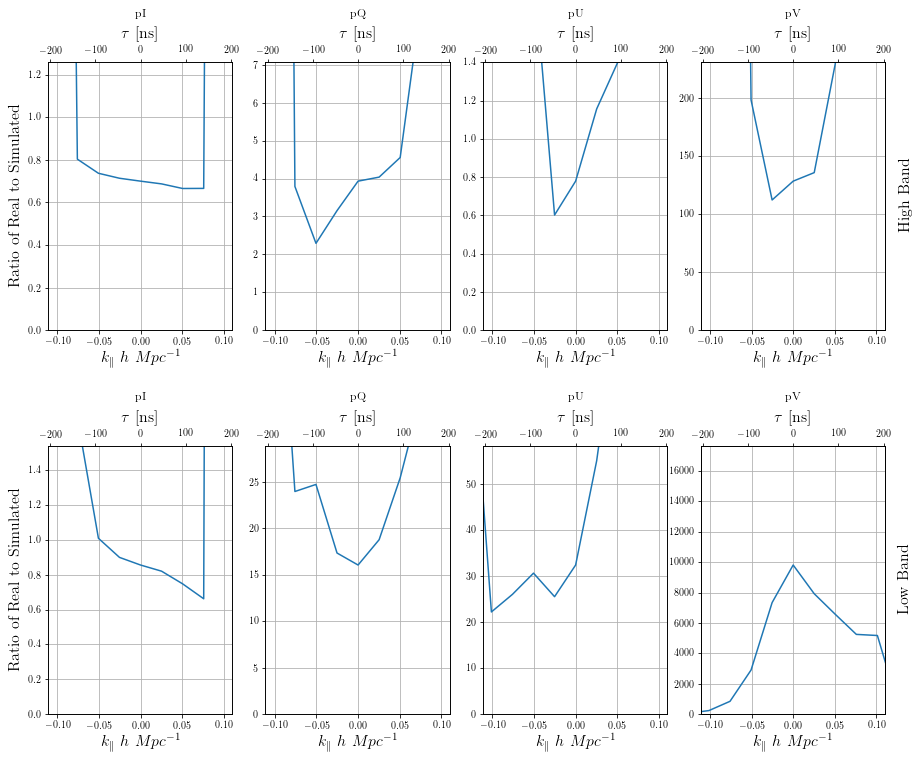

In [128]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15,12), sharex=False, sharey=False)
plt.subplots_adjust(wspace=0.18, hspace=.43)

for rowreal, rowsim, rowaxes, band in zip(plotted_real_data, plotted_sim_data, axes, highlow):
    for reald, simd, ax, pol in zip(rowreal, rowsim, rowaxes, pols):
        #plot data
        ratio = np.abs(reald)/np.abs(simd)
        ax.plot(kparas, ratio)
        #ymax = np.max(ratio[98:102])*1.8
        #print ymax/1.8
        ymax = ratio[len(ratio)/2] *1.8
        #print ymax/1.8
        ax.set_ylim([0,ymax])
        
        if pol != 'pI':
            ax.set_ylabel('')
        else:
            ax.set_ylabel('Ratio of Real to Simulated', fontsize=16)
        if pol == 'pV':
            axR = ax.twinx()
            axR.set_ylabel(band, fontsize=16)
            axR.set_yticklabels('')
            axR.yaxis.set_ticks_position('none')

        #get the x axes correctly zoomed in
        axT = ax.twiny()
        axT.set_xlim([delays[0],delays[-1]])
        
        labelpad=8
        axT.set_xlabel(r"$\tau$ $[{\rm ns}]$", fontsize=16, labelpad=labelpad)
        ax.set_xlabel("$k_{\parallel}\ h\ Mpc^{-1}$", fontsize=16)
        scale = .04
        axT.set_xlim([lim*scale for lim in axT.get_xlim()])
        ax.set_xlim([lim*scale for lim in ax.get_xlim()])

        ax.grid()
        ax.set_title(pol, pad=45)

fig.savefig(savepath + 'ps_ratio.pdf', bbox_inches='tight')